In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
sns.set(style='white', context='notebook', palette='deep')

## 2. Data Preparation

### 2.1 Load Data

In [4]:
train=pd.read_csv("Data/train.csv")
test=pd.read_csv("Data/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

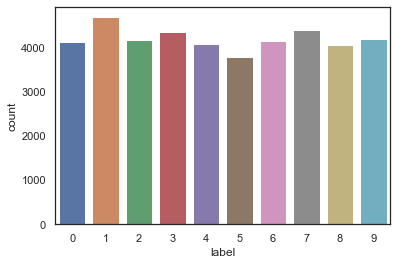

In [5]:
y_train=train.label
x_train=train.drop("label",axis=1)
g=sns.countplot(y_train)
y_train.value_counts()

### 2.2 check for null and missing values

In [6]:
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 2.3 normalization

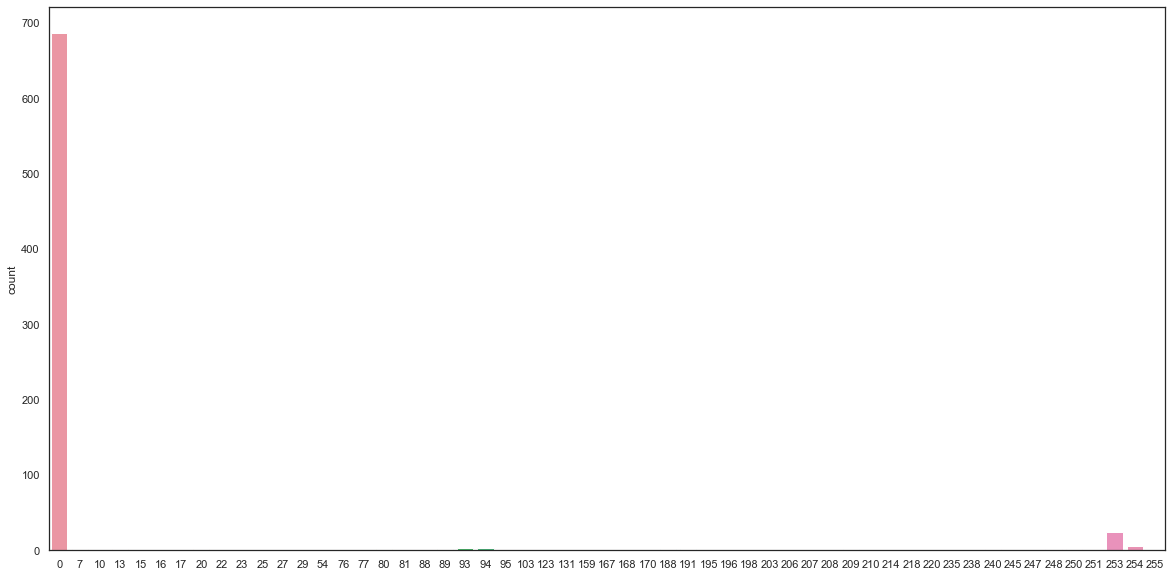

In [20]:
f,ax=plt.subplots(figsize=(20,10))
sns.countplot(x_train.iloc[0,:].values)

In [21]:
x_train/=255.0
test/=255.0

### 2.3 reshape

In [22]:
x_train=x_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

In [23]:
x_train.shape

(42000, 28, 28, 1)

### 2.5 label encoding

In [25]:
y_train=to_categorical(y_train,num_classes=10)

### 2.6 split training and validation set

In [27]:
x_trn,x_val,y_trn,y_val=train_test_split(x_train,y_train,test_size=0.1,random_state=2)

In [28]:
x_trn.shape,x_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1))

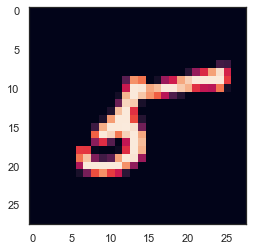

In [29]:
plt.imshow(x_trn[23][:,:,0])

## 3. cnn

### 3.1 define the model

In [31]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),padding="Same",
                 activation="relu",input_shape=(28,28,1)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding="Same",
                activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="Same",
                activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="Same",
                activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10,activation="softmax"))

### 3.2 Set the optimizer and annealer

In [32]:
optimizer=RMSprop(lr=0.001,rho=0.9,epsilon=1e-08,decay=0.0)

In [33]:
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

In [34]:
learning_rate_reduction=ReduceLROnPlateau(monitor="val_acc",
                                          patience=3,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr=0.00001)

In [35]:
epochs=1
batch_size=86

### 3.3 Data augmentation

In [36]:
# without data augmentation i obtained an accuracy of 0.98114
history = model.fit(x_trn,y_trn,batch_size=batch_size,epochs=epochs,
                   validation_data=(x_val,y_val),verbose=2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 12s - loss: 0.2448 - accuracy: 0.9214 - val_loss: 0.0720 - val_accuracy: 0.9771


# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

histroy=model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),
                           epochs=epochs,
                           validation_data=(x_val,y_val),
                           verbose=2,
                            steps_per_epoch=x_train.shape[0],
                            callbacks=[learning_rate_reduction])

## 4. Evaluate the model

## 4.1 training and validation curves

KeyError: 'acc'

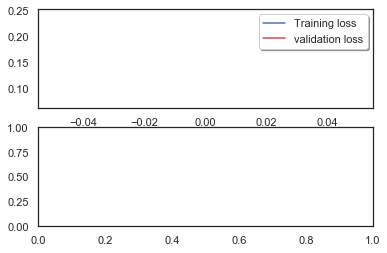

In [37]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


## 4.2 confusion matrix

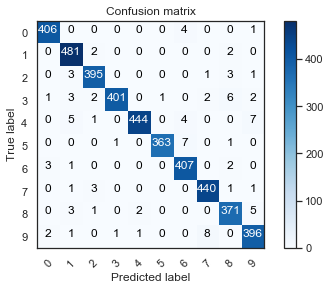

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

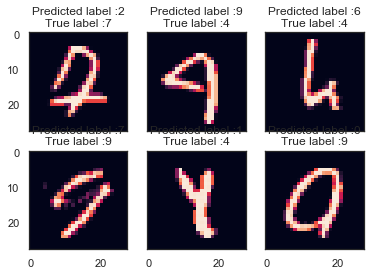

In [42]:

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [43]:
results=model.predict(test)
results=np.argmax(results,axis=1)
results=pd.Series(results,name="Label")

In [54]:
submission=pd.DataFrame({"ImageId":pd.Series(range(1,28001)),"Label":results.values})

In [56]:
from datetime import datetime
now=datetime.now()
submission.to_csv("data/{0:02d}{1:02d}{2:02d}{3:02d}_keras_submission.csv".format(now.year,now.month,now.day,now.hour),index=False)

In [57]:
print("Result",1652/2456)

Result 0.6726384364820847
